In [53]:
import pandas as pd

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def custom_classification_report(y_true, y_pred, target_names, class_indices):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_indices)

    # Initialize lists to store precision, recall, F1-score, and support for each class
    precision = []
    recall = []
    f1_score = []
    support = []

    # Calculate precision, recall, F1-score for each class
    for i in range(len(target_names)):
        true_positives = cm[i, i]
        false_positives = cm[:, i].sum() - true_positives
        false_negatives = cm[i, :].sum() - true_positives
        true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)

        # Precision: TP / (TP + FP)
        if true_positives + false_positives > 0:
            precision_i = true_positives / (true_positives + false_positives)
        else:
            precision_i = 0.0

        # Recall: TP / (TP + FN)
        if true_positives + false_negatives > 0:
            recall_i = true_positives / (true_positives + false_negatives)
        else:
            recall_i = 0.0

        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        if precision_i + recall_i > 0:
            f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
        else:
            f1_i = 0.0

        # Support: The number of true instances of each class
        support_i = cm[i, :].sum()

        # Append calculated metrics for this class
        precision.append(precision_i)
        recall.append(recall_i)
        f1_score.append(f1_i)
        support.append(support_i)

    # Calculate accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    # Calculate average F1-score for specified classes
    f1_average = np.mean([f1_score[i] for i in class_indices])

    # Print the aesthetically improved report
    print("Classification Report".center(65, "="))
    print(f"{'Class':<15}{'Precision':>12}{'Recall':>12}{'F1-Score':>12}{'Support':>12}")
    print("=" * 65)
    for i, label in enumerate(target_names):
        print(f"{label:<15}{precision[i]:>12.4f}{recall[i]:>12.4f}{f1_score[i]:>12.4f}{support[i]:>12}")
    print("=" * 65)
    print(f"Average F1-Score for classes : {f1_average:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print("Confusion Matrix".center(65, "="))
    disp.plot()
    plt.show()
    print("=" * 65, "\n")

class_indices = [0, 1, 2]

In [55]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [56]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,  # Number of classes
    'learning_rate': 0.001,
    'max_depth': 10,
    'subsample': 0.6478457734751482,
    'colsample_bytree': 0.9431214021788126,
    'random_state': 42,
}

def xgBoostPrediction(X_train, y_train, X_test, y_test, params, num_boost_round=462, target_names=None):

    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data = xgb.DMatrix(X_test, label=y_test)

    xgb_model = xgb.train(params, train_data,num_boost_round=num_boost_round)

    # Predict the class labels
    y_pred = xgb_model.predict(test_data)
    
    print('Expected features:', xgb_model.feature_names)
    print('Dataset columns:', X_train.columns.tolist())

    # Generate and print classification report
    print("xgBoost results:")
    custom_classification_report(y_test, y_pred, target_names=target_names,class_indices = [0, 1, 2])

In [57]:
from sklearn.ensemble import RandomForestClassifier

def rfPrediction(X_train, y_train, X_test, y_test, params, target_names = None):
    # creating a RF classifier
    clf = RandomForestClassifier(n_estimators = params['n_estimators'], 
                                 max_depth=params['max_depth'], 
                                 random_state=42, 
                                 min_samples_split=params['min_samples_split'], 
                                 min_samples_leaf=params['min_samples_leaf'])  
    
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    clf.fit(X_train, y_train)
    
    # performing predictions on the test dataset
    y_pred_rf = clf.predict(X_test)
    
    print("Random Forest results:")
    custom_classification_report(y_test, y_pred_rf, target_names=target_names,class_indices = [0, 1, 2])

In [58]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Ensure h0 and c0 are on the same device as input
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

In [59]:
from sklearn.model_selection import ParameterGrid

def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """
    Perform hyperparameter tuning using ParameterGrid
    
    Args:
        X_train (torch.Tensor): Training input data
        y_train (torch.Tensor): Training labels
        X_val (torch.Tensor): Validation input data
        y_val (torch.Tensor): Validation labels
        column (list, optional): Feature column names
    
    Returns:
        dict: Best hyperparameters
    """
    # Convert to numpy if tensor
    X_train = X_train.numpy() if torch.is_tensor(X_train) else X_train
    y_train = y_train.numpy() if torch.is_tensor(y_train) else y_train
    X_val = X_val.numpy() if torch.is_tensor(X_val) else X_val
    y_val = y_val.numpy() if torch.is_tensor(y_val) else y_val

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Define hyperparameter search space
    param_grid = {
        'hidden_size': [32, 64, 128],
        'num_layers': [2, 4, 8],
        'learning_rate': [0.001],
        'batch_size': [2, 4, 6],
        'dropout': [0.0, 0.2],
        'weight_decay': [0, 1e-5],
        'num_epochs': [20, 30]
    }
    
    # Generate all combinations
    param_combinations = list(ParameterGrid(param_grid))
    
    # Store results
    results = []
    
    # Prepare input parameters
    input_size = X_train_tensor.shape[2]
    num_classes = len(torch.unique(y_train_tensor))
    
    # Search through hyperparameters
    for params in param_combinations:
        # Create model
        model = LSTMModel(
            input_size=input_size,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            num_classes=num_classes,
            dropout=params['dropout']
        )
        
        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
        
        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(
            model.parameters(), 
            lr=params['learning_rate'], 
            weight_decay=params['weight_decay']
        )
        
        # Training loop
        best_val_accuracy = 0
        for epoch in range(params['num_epochs']):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            
            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()
            
            val_accuracy = 100 * correct / total
            best_val_accuracy = max(best_val_accuracy, val_accuracy)
        
        # Store results
        results.append((params, best_val_accuracy))
        best_params, best_accuracy = max(results, key=lambda x: x[1])
        print(f"Current Best Hyperparameters: {best_params}")
        print(f"Current Best Validation Accuracy: {best_accuracy:.2f}%")
    
    # Find best hyperparameters
    best_params, best_accuracy = max(results, key=lambda x: x[1])
    
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
    
    return best_params

In [60]:
if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

list_of_data = []

    
for data in os.listdir('processed_data'):
    list_of_data.append(f"processed_data\\{data}")
    

In [204]:
def DataEvaluation(dataset):
    transform_eeg_data = pd.read_csv(dataset)
    le = LabelEncoder()
    transform_eeg_data['GROUP'] = le.fit_transform(transform_eeg_data['GROUP'])
    # Convert object columns to numeric
    for col in transform_eeg_data.columns:
        if transform_eeg_data[col].dtype == 'object':
            transform_eeg_data[col] = pd.to_numeric(transform_eeg_data[col], errors='coerce')

    # Features and target
    X = transform_eeg_data.drop('GROUP', axis=1)
    y = transform_eeg_data['GROUP']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    xgBoost_params = {'objective': 'multi:softmax','learning_rate': 0.06924145688620424, 'max_depth': 5, 'n_estimators': 100, 'num_class': 3, 'random_state': 42, 'subsample': 0.8401537692938899}
    rf_params = {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}

    target_names=list(map(str,le.classes_))

    file_name = dataset.split('.')[0]
    print(f"For {file_name} data")

    xgBoostPrediction(X_train, y_train, X_test, y_test, target_names=target_names, params=xgBoost_params)
    rfPrediction(X_train, y_train, X_test,  y_test, params=rf_params, target_names=target_names)
    # logisticPrediction(X_train, y_train, X_test, y_test, target_names=target_names)



    # Prepare the data
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Best Hyperparameters: {'batch_size': 2, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 30, 'num_layers': 4, 'weight_decay': 0}
    # Current Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 4, 'weight_decay': 1e-05}
    # Current Best Hyperparameters: {'batch_size': 1, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 4, 'weight_decay': 1e-05}
    # Initialize the model, loss function, and optimizer
    input_size = X_train.shape[1]
    hidden_size = 64
    num_layers = 4
    num_classes = 3
    dropout = 0.0

    model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Train the model
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        

    # Evaluate the model
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())


    print("LSTM results:")
    custom_classification_report(y_true, y_pred, target_names=target_names,class_indices = [0, 1, 2])



For processed_data\Non_Standardized_data data
Expected features: ['sex', 'f7', 'c3', 'cp5', 'p3', 'o1', 'o2', 'p4', 'fc6', 'c1', 'cp3', 'p1', 'p6', 'af8', 'empty']
Dataset columns: ['sex', 'f7', 'c3', 'cp5', 'p3', 'o1', 'o2', 'p4', 'fc6', 'c1', 'cp3', 'p1', 'p6', 'af8', 'empty']
xgBoost results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.5000      0.8750      0.6364           8
1                    0.5000      0.3333      0.4000           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.3455
Accuracy : 0.5000
=========================Confusion Matrix========================


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


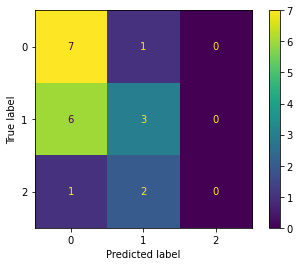


Random Forest results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.4375      0.8750      0.5833           8
1                    0.2500      0.1111      0.1538           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.2457
Accuracy : 0.4000
=========================Confusion Matrix========================


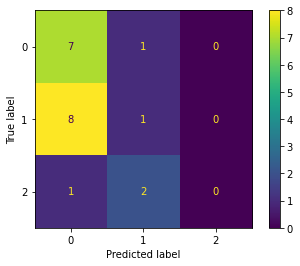


Epoch [1/20], Loss: 1.0703
Epoch [2/20], Loss: 1.0086
Epoch [3/20], Loss: 0.8984
Epoch [4/20], Loss: 0.8446
Epoch [5/20], Loss: 0.8227
Epoch [6/20], Loss: 0.8138
Epoch [7/20], Loss: 0.8087
Epoch [8/20], Loss: 0.8065
Epoch [9/20], Loss: 0.8063
Epoch [10/20], Loss: 0.8069
Epoch [11/20], Loss: 0.8078
Epoch [12/20], Loss: 0.8089
Epoch [13/20], Loss: 0.8107
Epoch [14/20], Loss: 0.8133
Epoch [15/20], Loss: 0.8167
Epoch [16/20], Loss: 0.8209
Epoch [17/20], Loss: 0.8253
Epoch [18/20], Loss: 0.8291
Epoch [19/20], Loss: 0.8317
Epoch [20/20], Loss: 0.8329
LSTM results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.4000      1.0000      0.5714           8
1                    0.0000      0.0000      0.0000           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.1905
Accuracy : 0.4000
=========================Confusion Matrix===============

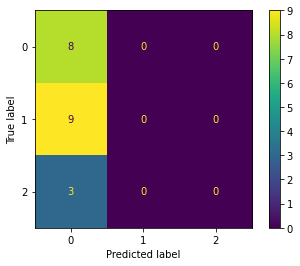

In [187]:
DataEvaluation(list_of_data[0])

For processed_data\Pure_data data
Expected features: ['sex', 'age', 'fp1', 'fz', 'f3', 'f7', 'below_eye', 'fc5', 'fc1', 'c3', 't7', 'left_mastoid', 'cp5', 'cp1', 'pz', 'p3', 'p7', 'o1', 'oz', 'o2', 'p4', 'p8', 'right_mastoid', 'cp6', 'cp2', 'cz', 'c4', 't8', 'above_eye', 'fc6', 'fc2', 'f4', 'f8', 'fp2', 'af7', 'af3', 'afz', 'f1', 'f5', 'ft7', 'fc3', 'fcz', 'c1', 'c5', 'tp7', 'cp3', 'p1', 'p5', 'po7', 'po3', 'poz', 'po4', 'po8', 'p6', 'p2', 'cp4', 'tp8', 'c6', 'c2', 'fc4', 'ft8', 'f6', 'f2', 'af4', 'af8', 'empty', 'ekg', 'audiooutput']
Dataset columns: ['sex', 'age', 'fp1', 'fz', 'f3', 'f7', 'below_eye', 'fc5', 'fc1', 'c3', 't7', 'left_mastoid', 'cp5', 'cp1', 'pz', 'p3', 'p7', 'o1', 'oz', 'o2', 'p4', 'p8', 'right_mastoid', 'cp6', 'cp2', 'cz', 'c4', 't8', 'above_eye', 'fc6', 'fc2', 'f4', 'f8', 'fp2', 'af7', 'af3', 'afz', 'f1', 'f5', 'ft7', 'fc3', 'fcz', 'c1', 'c5', 'tp7', 'cp3', 'p1', 'p5', 'po7', 'po3', 'poz', 'po4', 'po8', 'p6', 'p2', 'cp4', 'tp8', 'c6', 'c2', 'fc4', 'ft8', 'f6', 'f2',

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


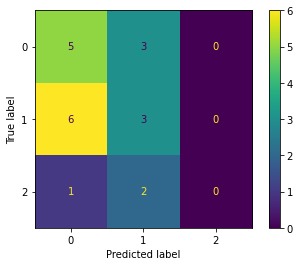


Random Forest results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.4000      0.7500      0.5217           8
1                    0.4000      0.2222      0.2857           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.2692
Accuracy : 0.4000
=========================Confusion Matrix========================


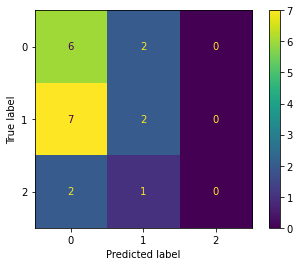


Epoch [1/20], Loss: 1.0317
Epoch [2/20], Loss: 0.9381
Epoch [3/20], Loss: 0.8545
Epoch [4/20], Loss: 0.8189
Epoch [5/20], Loss: 0.8042
Epoch [6/20], Loss: 0.7979
Epoch [7/20], Loss: 0.7968
Epoch [8/20], Loss: 0.7971
Epoch [9/20], Loss: 0.7971
Epoch [10/20], Loss: 0.7968
Epoch [11/20], Loss: 0.7966
Epoch [12/20], Loss: 0.7963
Epoch [13/20], Loss: 0.7961
Epoch [14/20], Loss: 0.7959
Epoch [15/20], Loss: 0.7958
Epoch [16/20], Loss: 0.7957
Epoch [17/20], Loss: 0.7957
Epoch [18/20], Loss: 0.7958
Epoch [19/20], Loss: 0.7959
Epoch [20/20], Loss: 0.7961
LSTM results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.4000      1.0000      0.5714           8
1                    0.0000      0.0000      0.0000           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.1905
Accuracy : 0.4000
=========================Confusion Matrix===============

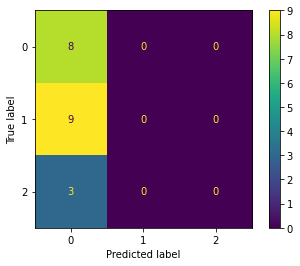

In [188]:
DataEvaluation(list_of_data[1])

For processed_data\Standardized_data data
Expected features: ['sex', 'f7', 'c3', 'cp5', 'p3', 'o1', 'o2', 'p4', 'fc6', 'c1', 'cp3', 'p1', 'p6', 'af8', 'empty']
Dataset columns: ['sex', 'f7', 'c3', 'cp5', 'p3', 'o1', 'o2', 'p4', 'fc6', 'c1', 'cp3', 'p1', 'p6', 'af8', 'empty']
xgBoost results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.5000      0.8750      0.6364           8
1                    0.5000      0.3333      0.4000           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.3455
Accuracy : 0.5000
=========================Confusion Matrix========================


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [23:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


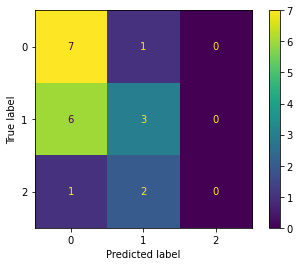


Random Forest results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.4375      0.8750      0.5833           8
1                    0.2500      0.1111      0.1538           9
2                    0.0000      0.0000      0.0000           3
Average F1-Score for classes : 0.2457
Accuracy : 0.4000
=========================Confusion Matrix========================


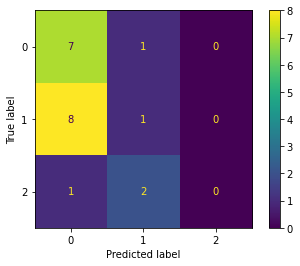


Epoch [1/20], Loss: 1.0640
Epoch [2/20], Loss: 0.9255
Epoch [3/20], Loss: 0.4895
Epoch [4/20], Loss: 0.2047
Epoch [5/20], Loss: 0.1780
Epoch [6/20], Loss: 0.1527
Epoch [7/20], Loss: 0.1403
Epoch [8/20], Loss: 0.1312
Epoch [9/20], Loss: 0.1165
Epoch [10/20], Loss: 0.0899
Epoch [11/20], Loss: 0.0578
Epoch [12/20], Loss: 0.0393
Epoch [13/20], Loss: 0.0205
Epoch [14/20], Loss: 0.0140
Epoch [15/20], Loss: 0.0079
Epoch [16/20], Loss: 0.0083
Epoch [17/20], Loss: 0.0040
Epoch [18/20], Loss: 0.0025
Epoch [19/20], Loss: 0.0019
Epoch [20/20], Loss: 0.0013
LSTM results:
======================Classification Report======================
Class             Precision      Recall    F1-Score     Support
0                    0.7778      0.8750      0.8235           8
1                    0.8750      0.7778      0.8235           9
2                    1.0000      1.0000      1.0000           3
Average F1-Score for classes : 0.8824
Accuracy : 0.8500
=========================Confusion Matrix===============

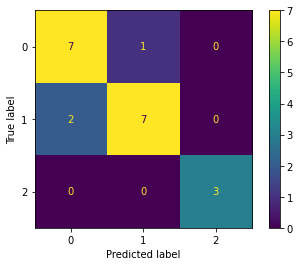

In [208]:
DataEvaluation(list_of_data[2])

In [154]:
# LSTM Hyperparameter Tuning
def LSTM_Hyper_tuning(dataset):
    transform_eeg_data = pd.read_csv(dataset)
    le = LabelEncoder()
    transform_eeg_data['GROUP'] = le.fit_transform(transform_eeg_data['GROUP'])
    # Convert object columns to numeric
    for col in transform_eeg_data.columns:
        if transform_eeg_data[col].dtype == 'object':
            transform_eeg_data[col] = pd.to_numeric(transform_eeg_data[col], errors='coerce')

    # Features and target
    X = transform_eeg_data.drop('GROUP', axis=1)
    y = transform_eeg_data['GROUP']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


    target_names=list(map(str,le.classes_))

    file_name = dataset.split('.')[0]
    print(f"For {file_name} data")

    # Prepare the data
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    print("\n Hyperparameter Tuning on LSTM:")
    hyperparameter_tuning(X_train=X_train_tensor, y_train=y_train_tensor, X_val=X_test_tensor, y_val=y_test_tensor)

In [157]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

def xg_Hyper_tuning(dataset):

    transform_eeg_data = pd.read_csv(dataset)
    le = LabelEncoder()
    transform_eeg_data['GROUP'] = le.fit_transform(transform_eeg_data['GROUP'])
    # Convert object columns to numeric
    for col in transform_eeg_data.columns:
        if transform_eeg_data[col].dtype == 'object':
            transform_eeg_data[col] = pd.to_numeric(transform_eeg_data[col], errors='coerce')

    # Features and target
    X = transform_eeg_data.drop('GROUP', axis=1)
    y = transform_eeg_data['GROUP']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


    target_names=list(map(str,le.classes_))

    file_name = dataset.split('.')[0]
    print(f"For {file_name} data")

    param_dist = {
        'max_depth': stats.randint(3, 10),
        'learning_rate': stats.uniform(0.01, 0.1),
        'subsample': stats.uniform(0.5, 0.5),
        'random_state': [42],
        'num_class': [3]
    }

    xgb_model = xgb.XGBClassifier()

    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                    n_iter=100, scoring='accuracy', cv=15, 
                                    verbose=2, n_jobs=-1, random_state=42)

# Perform grid search
    random_search.fit(X_train, y_train)
        # Best parameters and score
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)

    # Evaluate the model on the test set
    best_model = random_search.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print("Test Accuracy:", test_accuracy)


In [158]:
from sklearn.model_selection import RandomizedSearchCV

def rf_Hyper_tuning(dataset):

    transform_eeg_data = pd.read_csv(dataset)
    le = LabelEncoder()
    transform_eeg_data['GROUP'] = le.fit_transform(transform_eeg_data['GROUP'])
    # Convert object columns to numeric
    for col in transform_eeg_data.columns:
        if transform_eeg_data[col].dtype == 'object':
            transform_eeg_data[col] = pd.to_numeric(transform_eeg_data[col], errors='coerce')

    # Features and target
    X = transform_eeg_data.drop('GROUP', axis=1)
    y = transform_eeg_data['GROUP']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


    target_names=list(map(str,le.classes_))

    file_name = dataset.split('.')[0]
    print(f"For {file_name} data")

    param_dist = {
        'n_estimators': stats.randint(25,250),
        'max_depth': stats.randint(1, 40),
        'min_samples_split': stats.randint(2,10),
        'min_samples_leaf': stats.randint(1,5),
    }

    rf = RandomForestClassifier()

    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                    n_iter=100, scoring='accuracy', cv=15, 
                                    verbose=2, n_jobs=-1, random_state=42)

    # Perform random search
    random_search.fit(X_train, y_train)

# Best parameters
        # Best parameters and score
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)

    # Evaluate the model on the test set
    best_model = random_search.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print("Test Accuracy:", test_accuracy)


In [162]:
LSTM_Hyper_tuning(list_of_data[2])

For processed_data\Standardized_data data

 Hyperparameter Tuning on LSTM:
Current Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 2, 'weight_decay': 0}
Current Best Validation Accuracy: 50.00%
Current Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 2, 'weight_decay': 0}
Current Best Validation Accuracy: 50.00%
Current Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 2, 'weight_decay': 0}
Current Best Validation Accuracy: 50.00%
Current Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 4, 'weight_decay': 1e-05}
Current Best Validation Accuracy: 55.00%
Current Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 32, 'learning_rate': 0.001, 'num_e

In [159]:
rf_Hyper_tuning(list_of_data[2])

For processed_data\Standardized_data data
Fitting 15 folds for each of 100 candidates, totalling 1500 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=15.
  warnings.warn(


Best Parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 128}
Best Score: 0.5333333333333333
Test Accuracy: 0.4


In [160]:
xg_Hyper_tuning(list_of_data[2])

For processed_data\Standardized_data data
Fitting 15 folds for each of 100 candidates, totalling 1500 fits


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=15.
  warnings.warn(


Best Parameters: {'learning_rate': 0.024092422497476264, 'max_depth': 9, 'num_class': 3, 'random_state': 42, 'subsample': 0.5826334695315012}
Best Score: 0.5
Test Accuracy: 0.55


In [ ]:
LSTM_Hyper_tuning(list_of_data[1])

#### First LSTM Hyperparameter Tuning on Standardized Data:
***
Param:
    param_grid = {
        'hidden_size': [64, 128],
        'num_layers': [1, 2],
        'learning_rate': [0.001],
        'batch_size': [4],
        'dropout': [0.0, 0.2, 0.5],
        'weight_decay': [0, 1e-5],
        'num_epochs': [50, 70]
    }
-    Train_Shuffle = False
-    Test_Shuffle = False
-    test_size = 0.4 (40%)

- Best Hyperparameters: {'batch_size': 4, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 50, 'num_layers': 2, 'weight_decay': 0}
- Best Validation Accuracy: 75.00%
- Best Average F1-Score for classes : 0.6868
***


#### Second LSTM Hyperparameter Tuning on Standardized Data:
***
Param:
    param_grid = {
        'hidden_size': [64, 128, 256],
        'num_layers': [2, 4, 8, 16],
        'learning_rate': [0.001],
        'batch_size': [4, 8, 16],
        'dropout': [0.0, 0.2],
        'weight_decay': [0, 1e-4],
        'num_epochs': [50]
    }
-    Train_Shuffle = False
-    Test_Shuffle = False
-    test_size = 0.4 (40%)

- Best Hyperparameters: {'batch_size': 4, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 50, 'num_layers': 4, 'weight_decay': 0}
- Best Validation Accuracy: 80.00%
- Best Average F1-Score for classes : 0.8004
***

#### Third LSTM Hyperparameter Tuning on Standardized Data:
***
Param:
    param_grid = {
        'hidden_size': [64, 128],
        'num_layers': [2, 4],
        'learning_rate': [0.001],
        'batch_size': [1 ,2, 4],
        'dropout': [0.0, 0.2],
        'weight_decay': [0, 1e-4],
        'num_epochs': [20, 30, 50]
    }
-    Train_Shuffle = False
-    Test_Shuffle = False
-    test_size = 0.4 (40%)

- Best Hyperparameters: {'batch_size': 1, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 4, 'weight_decay': 0}
- Best Validation Accuracy: 80.00%
- Best Average F1-Score for classes : 0.8426
***

#### Fourth LSTM Hyperparameter Tuning on Standardized Data:
***
Param:
    param_grid = {
        'hidden_size': [32, 64, 128],
        'num_layers': [2, 4],
        'learning_rate': [0.001],
        'batch_size': [1 ,2, 4],
        'dropout': [0.0, 0.2],
        'weight_decay': [0, 1e-4],
        'num_epochs': [20, 30, 50]
    }
-    Train_Shuffle = False
-    Test_Shuffle = False
-    test_size = 0.4 (40%)

- Best Hyperparameters: {'batch_size': 1, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 50, 'num_layers': 4, 'weight_decay': 0}
- Best Validation Accuracy: 85.00% (Yet, unachievable in real training)
- Best Average F1-Score for classes : ?? (Best Possible with 0.8004 along with 80.00% accuracy)
***

#### Fifth LSTM Hyperparameter Tuning on Standardized Data:
***
Param:
    param_grid = {
        'hidden_size': [32, 64, 128],
        'num_layers': [2, 4, 8],
        'learning_rate': [0.001],
        'batch_size': [2, 4, 6],
        'dropout': [0.0, 0.2],
        'weight_decay': [0, 1e-5],
        'num_epochs': [20, 30]
    }
-    Train_Shuffle = False
-    Test_Shuffle = False
-    test_size = 0.3 (30%)

- Best Hyperparameters: {'batch_size': 2, 'dropout': 0.2, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 30, 'num_layers': 4, 'weight_decay': 0}
- Best Validation Accuracy: 80.00% (Best on real training 73.33%)
- Best Average F1-Score for classes : ?? (Best Possible with 0.7937 along with 73.33% accuracy)
***

#### Sixth LSTM Hyperparameter Tuning on Standardized Data:
***
Param:
    param_grid = {
        'hidden_size': [32, 64, 128],
        'num_layers': [2, 4, 8],
        'learning_rate': [0.001],
        'batch_size': [2, 4, 6],
        'dropout': [0.0, 0.2],
        'weight_decay': [0, 1e-5],
        'num_epochs': [20, 30]
    }
-    Train_Shuffle = False
-    Test_Shuffle = False
-    test_size = 0.3 (30%)

- Best Hyperparameters: {'batch_size': 2, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 4, 'weight_decay': 1e-05}
- Best Validation Accuracy: 85.00%
- Best Average F1-Score for classes : ?? (Best Possible with 0.7937 along with 73.33% accuracy)
***

***
- Although without Hyperparameter Tuning current possible accuracy is 85.00% with Best Average F1-Score for classes : 0.8824

- Current Best Hyperparameters: {'batch_size': 1, 'dropout': 0.0, 'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'num_layers': 4, 'weight_decay': 1e-05}
- Test_data = 0.4 (40%)
- Train_Shuffle = False
- Test_Shuffle = False

***

#### First RF Hyperparameter Tuning on Standardized Data:
***
Param:
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
-    test_size = 0.3 (30%)

- Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
- Best Validation Accuracy: 0.5555555555555555
- Best Average F1-Score for classes : 0.8004
***

In [40]:
# # Applying PCA function on training
# # and testing set of X component
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.90)

# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# explained_variance = pca.explained_variance_ratio_

In [41]:
# explained_variance

In [42]:
# train_data_pca = xgb.DMatrix(X_train_pca, label=y_train)
# test_data_pca = xgb.DMatrix(X_test_pca, label=y_test)

# xgb_model_pca = xgb.train(params, train_data_pca,num_boost_round=462)

# # Predict the class labels
# y_pred_pca = xgb_model_pca.predict(test_data_pca)

In [43]:
# # Generate and print classification report
# report = custom_classification_report(y_test, y_pred_pca, target_names=target_names,class_indices = [0, 1, 2])

In [44]:
# from sklearn.ensemble import RandomForestClassifier


# # creating a RF classifier
# clf = RandomForestClassifier(n_estimators = 100)  
 
# # Training the model on the training dataset
# # fit function is used to train the model using the training sets as parameters
# clf.fit(X_train_pca, y_train)
 
# # performing predictions on the test dataset
# y_pred_rf = clf.predict(X_test_pca)
 
# custom_classification_report(y_test, y_pred_rf, target_names=target_names,class_indices = [0, 1, 2])

In [45]:
# from sklearn.linear_model import LogisticRegression

# # creating a RF classifier
# log_reg = LogisticRegression(random_state=42)
 
# # Training the model on the training dataset
# # fit function is used to train the model using the training sets as parameters
# log_reg.fit(X_train_pca, y_train)
 
# # performing predictions on the test dataset
# y_pred_log_reg = log_reg.predict(X_test_pca)
 
# custom_classification_report(y_test, y_pred_log_reg, target_names=target_names,class_indices = [0, 1, 2])

In [46]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import f1_score, accuracy_score

# import torch.nn as nn
# import torch.optim as optim

# # Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
    
#     def forward(self, x):
#         h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
#         c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])  # Extract the output from the last time step
#         return out

# # Prepare the data
# X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32).unsqueeze(1)
# y_train_pca_tensor = torch.tensor(y_train.values, dtype=torch.long)
# X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32).unsqueeze(1)
# y_test_pca_tensor = torch.tensor(y_test.values, dtype=torch.long)

# train_pca_dataset = TensorDataset(X_train_pca_tensor, y_train_pca_tensor)
# test_pca_dataset = TensorDataset(X_test_pca_tensor, y_test_pca_tensor)

# train_pca_loader = DataLoader(train_pca_dataset, batch_size=4, shuffle=True)
# test_pca_loader = DataLoader(test_pca_dataset, batch_size=4, shuffle=True)

# # Initialize the model, loss function, and optimizer
# input_size = X_train.shape[1]
# hidden_size = 128
# num_layers = 4
# num_classes = 3

# model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# num_epochs = 50
# for epoch in range(num_epochs):
#     model.train()
#     for X_batch, y_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluate the model
# model.eval()
# y_true = []
# y_pred = []
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = model(X_batch)
#         _, predicted = torch.max(outputs.data, 1)
#         y_true.extend(y_batch.numpy())
#         y_pred.extend(predicted.numpy())

# # Calculate F1 score and accuracy
# f1 = f1_score(y_true, y_pred, average='weighted')
# accuracy = accuracy_score(y_true, y_pred)

# print(f'F1 Score: {f1:.4f}')
# print(f'Accuracy: {accuracy * 100:.2f}%')